<a href="https://colab.research.google.com/github/Azimoj/Classifier-automatiquement-des-biens-de-consommation/blob/main/text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The "Marketplace" company is launching an e-commerce marketplace where sellers offer items by posting a photo and description. Currently the categorization of the small number of products is done manually. The e-commerce site aims to expand and significantly increase the number of products, and manual categorization would be a long and unreliable step. To facilitate the posting of new articles and the search for products, it becomes necessary to automate this task. This categorization will be done from the descriptions and images of the products.

La mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

### **Text Analysis**

https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

In [ ]:
pip install "gensim==3.8.1"

     |████████████████████████████████| 24.2 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# Data Structures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Corpus Processing
import nltk
nltk.download('stopwords')
import string
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#from nltk import SnowballStemmer,PorterStemmer
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

from sklearn.metrics import adjusted_rand_score

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import    gensim
from gensim import corpora
from pprint  import pprint
import  gensim.downloader
from gensim import matutils, utils
from gensim.corpora                   import Dictionary

from gensim.models                    import CoherenceModel
from gensim.models                    import LdaModel
from gensim.models                    import TfidfModel

from gensim.parsing.preprocessing     import preprocess_string

In [4]:
#Download databases
flipkart= pd.read_csv('/content/drive/MyDrive/p6/flipkart_com-ecommerce_sample_1050.csv',sep=',')
flipkart.head(3)

uniq_id  ...                             product_specifications
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  {"product_specification"=>[{"key"=>"Brand", "v...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  {"product_specification"=>[{"key"=>"Machine Wa...
2  64d5d4a258243731dc7bbb1eef49ad74  ...  {"product_specification"=>[{"key"=>"Material",...

[3 rows x 15 columns]

In [5]:
data_con=flipkart.copy()

In [6]:
del data_con['is_FK_Advantage_product']  # Boolean
del data_con['crawl_timestamp']

In [7]:
data_con['uniq_id'].duplicated().sum()

0

In [8]:
data_con.shape

(1050, 13)

In [ ]:
data_con.isnull().sum()

uniq_id                     0
product_url                 0
product_name                0
product_category_tree       0
pid                         0
retail_price                1
discounted_price            1
image                       0
description                 0
product_rating              0
overall_rating              0
brand                     338
product_specifications      1
dtype: int64

 ***We have some missing values!!***

---



### **Missing values and imputation**

In [ ]:
import missingno as msno

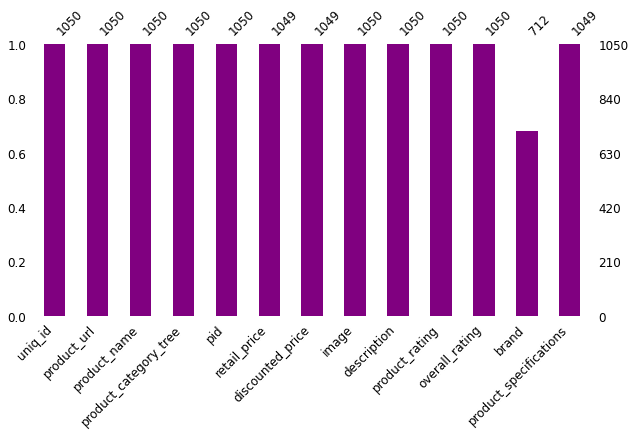

In [ ]:
msno.bar(data_con,  figsize=(10,5), fontsize=12, color="purple")

there is missing value for 'retail_price' , 'discounted_price' , 'brand' & 'product_specifications'

**Imputation**

In [9]:
data_con['retail_price'].fillna((data_con['retail_price'].median()), inplace=True)
data_con['discounted_price'].fillna((data_con['discounted_price'].median()), inplace=True)

In [10]:
data_con['brand'].fillna((data_con['brand'].mode()[0]), inplace=True)
data_con['product_specifications'].fillna((data_con['product_specifications'].mode()[0]), inplace=True)

In [ ]:
data_con.isnull().sum()

uniq_id                   0
product_url               0
product_name              0
product_category_tree     0
pid                       0
retail_price              0
discounted_price          0
image                     0
description               0
product_rating            0
overall_rating            0
brand                     0
product_specifications    0
dtype: int64

### **Data Exploration**

In [11]:
data = data_con.filter(items=['uniq_id','image', 'product_name', 'product_category_tree', 'description'])

## **Cleaning dataset & visualisation**

### Product Name

In [ ]:
data['product_name'].unique()

array(['Elegance Polyester Multicolor Abstract Eyelet Door Curtain',
       'Sathiyas Cotton Bath Towel',
       'Eurospa Cotton Terry Face Towel Set', ...,
       'Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker',
       'Wallmantra Medium Vinyl Sticker Sticker',
       'Uberlyfe Large Vinyl Sticker'], dtype=object)

In [ ]:
data['product_category_tree'].sample(5)

733     ["Computers >> Computer Peripherals >> Printer...
749     ["Home Furnishing >> Bed Linen >> Blankets, Qu...
821     ["Home Furnishing >> Bed Linen >> Blankets, Qu...
1011    ["Baby Care >> Baby Grooming >> Cotton Buds >>...
246     ["Kitchen & Dining >> Cookware >> Pots & Pans ...
Name: product_category_tree, dtype: object

In [ ]:
data['description'].sample(5)

211    Lal Haveli Wooden Table Decor Mother & Baby El...
762    Perucci PC-303 Analog Watch  - For Men - Buy P...
12     Lois Caron LCS-4032 Analog Watch  - For Boys, ...
959    Key Features of GIMS Brown Viscose Carpet soft...
807    Mxofere Combo Sandal Turmeric Almond Honey Jas...
Name: description, dtype: object

**Cleaning 'product_category_tree' column**

In [ ]:
data['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [12]:
data['category']=data['product_category_tree'].str.split(pat=">>",expand=True)[0]

data["category"] = data["category"].str.replace('[', "")
data["category"] = data["category"].str.replace('"', "")
data["category"] = data["category"].str.replace(' ', "")

catg  = {'HomeFurnishing':'Home',
         'HomeDecor&FestiveNeeds':'Decor',
         'Watches':'Watches',
         'BabyCare':'Baby',
         'BeautyandPersonalCare':'Beauty',
         'Computers':'Computers',
         'Kitchen&Dining':'Kitchen'}
data['category'] =[catg[i] for i in data['category']]
cluster  = {'Baby':0,
           'Decor':1,
           'Computers':2,
           'Watches':3,
           'Kitchen':4,
           'Home':5,
           'Beauty':6}

label_category = data['category'].map(cluster)
data["label_category"] = label_category

In [13]:
data['category_1']=data['product_category_tree'].str.split(
    pat=">>",expand=True)[1]
data["category_1"] = data["category_1"].str.replace('[', "")
data["category_1"] = data["category_1"].str.replace('"', "")
data["category_1"] = data["category_1"].str.replace(' ', "")

In [ ]:
data['category'].value_counts()

Computers    150
Beauty       150
Kitchen      150
Watches      150
Decor        150
Home         150
Baby         150
Name: category, dtype: int64

In [ ]:

data.describe(include='all').T

count unique  ...  75%  max
uniq_id                1050   1050  ...  NaN  NaN
image                  1050   1050  ...  NaN  NaN
product_name           1050   1050  ...  NaN  NaN
product_category_tree  1050    642  ...  NaN  NaN
description            1050   1050  ...  NaN  NaN
category               1050      7  ...  NaN  NaN
label_category         1050    NaN  ...    5    6
category_1             1050     63  ...  NaN  NaN

[8 rows x 11 columns]

In [ ]:
data.drop('product_category_tree',inplace=True, axis=1)

In [ ]:
data.head()

uniq_id  ...            category_1
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  Curtains&Accessories
1  7b72c92c2f6c40268628ec5f14c6d590  ...         BabyBath&Skin
2  64d5d4a258243731dc7bbb1eef49ad74  ...         BabyBath&Skin
3  d4684dcdc759dd9cdf41504698d737d8  ...              BedLinen
4  6325b6870c54cd47be6ebfbffa620ec7  ...              BedLinen

[5 rows x 7 columns]

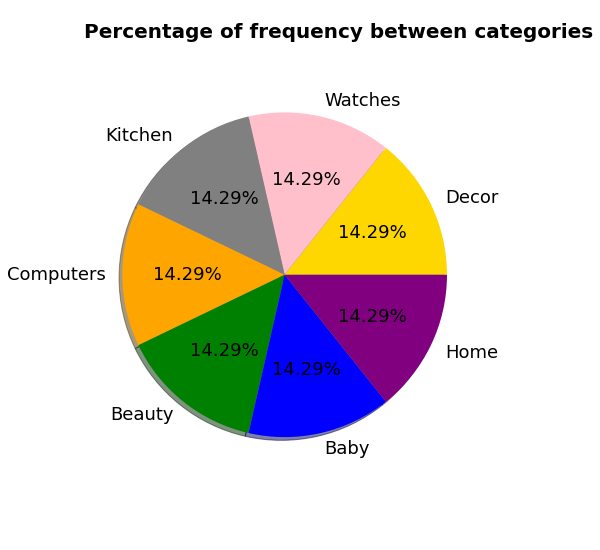

In [ ]:
values = data['category'].value_counts()
labels = data['category'].value_counts().index
colors = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple']
explode = (0, 0, 0, 0, 0, 0, 0)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct='%.2f%%', shadow=True, textprops={'fontsize': 18})

ttl = plt.title( "Percentage of frequency between categories",  fontweight = 'bold' ,fontsize=20,pad=50)

ttl.set_position([0.65, 0.85])
plt.axis('equal')
plt.tight_layout()

In [ ]:
pd.set_option('display.max_row',62)
data['category_1'].value_counts().head(20)
#Nous avons 62 catégories 
#c'est plus détaille que les categories de la colonne cat_lvl1

WristWatches              149
LaptopAccessories          87
InfantWear                 84
CoffeeMugs                 74
Showpieces                 71
BedLinen                   65
Fragrances                 65
NetworkComponents          49
TableDecor&Handicrafts     27
Cookware                   27
CombosandKits              24
WallDecor&Clocks           22
BathLinen                  21
Curtains&Accessories       19
Makeup                     18
BodyandSkinCare            15
BabyBedding                15
Baby&KidsGifts             15
Kitchen&DiningLinen        14
KitchenTools               14
Name: category_1, dtype: int64

### **Text Preprocessing**

* remove punctional
* keep only alphabetic characters
* remove stopwords and isolated letters
* put all words in lowercase
* lemmatization
* keep only the canonical forms of words



In [ ]:
data['description'].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

In [ ]:
data['description'].sample(5)

986    Buy Vedic Deals Couple Radium Statues Showpiec...
732    Sonpra Baby Boy's Bodysuit\r\n                ...
597    Key Features of LITTLE FEETZ Baby Girl's Solid...
932    Buy Valtellina Abstract Double Blanket Brown a...
235    Celebrity Wheel Pizza Cutter (Carbon Steel Pac...
Name: description, dtype: object

In [ ]:
len(data['description'])

1050

**Function for the number of words**

In [14]:
def word_size(base,columns):
  corpus=base[columns]

  words_dico=dict()
  import re
  #importation regular expressions

  expr = re.compile("\W+",re.U) # Regular expression of segmentation on spaces
  for text in corpus: # For each comment in the corpus
    x = str(text)
    text = expr.split(x)
    for word in set(text): # Retrieving each new word
      if word not in words_dico:
        words_dico[word]=1
      else: 
          # For each word already listed: add 1 if it is found
            words_dico[word]=words_dico[word]+1

  return len(words_dico)

In [15]:
size=word_size(data,'description')
print(size)


7671


In [ ]:
size=word_size(data,'product_name')
print(size)

2531



$\color{orange}{\text{1- Lower word}}$







In [16]:
data["description_clean"] = data["description"].apply(lambda x: x.lower())
data["name_clean"] = data["product_name"].apply(lambda x: x.lower())

display(data.sample(2))

uniq_id  ...                                         name_clean
201  9c4ab8ab059c912090c83cb0818e7f1c  ...  lal haveli rajasthani wooden crafted unique ch...
983  b58309ed929c2bf7d6096c03667b654f  ...           yk striped baby boy's round neck t-shirt

[2 rows x 10 columns]

In [ ]:
size=word_size(data,'description_clean')
print(size)

6086


In [ ]:
size=word_size(data,'name_clean')
print(size)

2387


$\color{orange}{\text{2- Contraction}}$


we will or we shouldnt've -> we should not have.

In [17]:
!pip install contractions

     |████████████████████████████████| 284 kB 28.4 MB/s 
     |████████████████████████████████| 321 kB 65.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85439 sha256=d0990f5da37759eda69b7274877f5f161c2417b9aff74d71d6622ce840e7b610
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [18]:
import contractions
data["description_clean"] = data["description_clean"].apply(lambda x: contractions.fix(x))
data["name_clean"] = data["name_clean"].apply(lambda x: contractions.fix(x))

display(data.sample(2))

uniq_id  ...                                         name_clean
563  e15195f2a5ebaa2168ccd65324e65e8e  ...  fluid fs201-bl01 analog-digital watch  - for w...
438  ee78c1e94bdc217d1d0eaef5c567417a  ...          budding bees printed baby girl's jumpsuit

[2 rows x 10 columns]

In [ ]:
size=word_size(data,'description_clean')
print(size)

6076


In [ ]:
size=word_size(data,'name_clean')
print(size)

2386


$\color{orange}{\text{3- Punctual words}}$



* To add space after all punctual words

In [19]:
oldstr=data['description_clean'][0]
re.sub(r'\.([a-zA-Z])', r'. \1', oldstr)
re.sub(r'\,([a-zA-Z])', r', \1', oldstr)

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain, elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so that yo

In [20]:
def add_space(oldstr):
  oldstr=re.sub(r'\.([a-zA-Z])', r'. \1', oldstr) # Add space after . & ,
  oldstr=re.sub(r'\,([a-zA-Z])', r', \1', oldstr)
  return oldstr

In [21]:
data["description_clean"] = data["description_clean"].apply(lambda x: add_space(x))

In [22]:
data['description_clean'][0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain, elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors. this curtain is made from 100% high quality polyester fabric. it features an eyelet style stitch with metal ring. it makes the room environment romantic and loving. this curtain is ant- wrinkle and anti shrinkage and have elegant apparance. give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so th

Removing punctual words & numbers ...

In [23]:

def remove_Noise(text):
    """
        Remove URLs from a sample string
    """
    text=text.translate(str.maketrans(' ', ' ', string.punctuation)) #remove ponctuation,
    text = text.rstrip('\n')              # Removes line breaks
    text=re.sub(r"https?://\S+|www\.\S+", "  ", text)
    #html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    #text=re.sub(html, "", text)
    text =re.sub(r'[^\x00-\x7f]',r' ', text) #Remove non-ASCII characters
    text=re.sub('\W_',' ', text)        # removes specials characters and leaves only words
    text = re.sub("\S*\d\S*","  ", text)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    text = re.sub("\S*@\S*\s?","  ", text) # removes emails and mentions (words with @)
    return text

In [24]:
data["description_clean"] = data["description_clean"].apply(lambda x: remove_Noise(x))
data["name_clean"] = data["name_clean"].apply(lambda x: remove_Noise(x))

display(data.sample(2))

uniq_id  ...                                       name_clean
344  6e44d107ee32412243b19b0ed9b415f3  ...     anna andre paris majesty deodorant combo set
742  a97b85d31d715c65b2970c4177eb0fda  ...  nutcase sticker wrap design  north    ml bottle

[2 rows x 10 columns]

In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
#test
idex=450
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text modifier#  : specifications of upside down sleeveless applique baby girls baby boys jacket general details ideal for baby girls baby boys pattern applique jacket details fabric poly cotton reversible no hooded no closure buttons sleeve sleeveless lining cotton fabric care do not wash with other garments hand wash with mild detergent do not tumble dry dry in shade additional details style code light pink smiley face jacket other details sleeveless in the box    jacket


In [ ]:
size=word_size(data,'description_clean')
print(size)

5059


In [ ]:
size=word_size(data,'name_clean')
print(size)

1884


In [25]:
def remove_special_characters(text):

    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [26]:
data["description_clean"] = data["description_clean"].apply(lambda x: remove_special_characters(x))
data["name_clean"] = data["name_clean"].apply(lambda x: remove_special_characters(x))

In [ ]:
size=word_size(data,'description_clean')
print(size)

5059


In [ ]:
size=word_size(data,'name_clean')
print(size)

1884


In [27]:
def wordcloud(corpus):
  corpus_wordcloud = WordCloud().generate(corpus)
  plt.imshow(corpus_wordcloud)
  plt.axis('off')
  plt.show()

Texte original   Nombre de tokens: 67
--------------
specifications of sathiyas cotton bath towel    bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm    model name sathiyas cotton bath towel ideal for men women boys girls model id    color red yellow blue size mediam dimensions length    inch width    inch in the box number of contents in sales package    sales package    bath towel


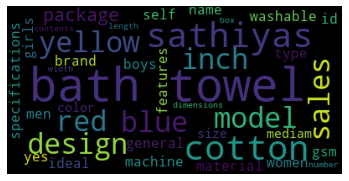

In [28]:
# Paramètre
p_id = 1
content = data.loc[p_id,'description_clean']

prec, tokens_nb = ' ', 0
for char in content:
  tokens_nb += int(prec == ' ' and char != ' ')
  prec = char

process_step = 'Texte original'
print(process_step,'  Nombre de tokens:',tokens_nb)
print(len(process_step)*'-')
print(content)

wordcloud(content)

$\color{orange}{\text{4- Tokenize}}$


Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.


1.   Character tokens: s-m-a-r-t-e-r
2.   Subword tokens: smart-er
3.   Word tokenization:  Never-give-up

https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/

https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/

In [29]:
def tokenization(text):
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  tokens=tokenizer.tokenize(text)
  return tokens

In [30]:
# Tokenizing  texts.
from nltk.tokenize import word_tokenize
nltk.download('punkt')

data['description_tokenized'] = data["description_clean"].apply(lambda x: tokenization(x))
data['name_tokenized'] = data["name_clean"].apply(lambda x: tokenization(x))
display(data.sample(2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


uniq_id  ...                                     name_tokenized
110  f1ee63a5f0db853e2c1b377778580d39  ...                   [twisha, printed, kurti, salwar]
991  06fdaa2b03d70da4358311d260456729  ...  [seven, seas, stainless, steel, twisting, pull...

[2 rows x 12 columns]

In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)
text_tokenized=data['description_tokenized'][idex]
print('#text tokenized#  :',text_tokenized)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
size_f_Td=word_size(data,'description_tokenized')
print(size_f_Td)

5059


In [ ]:
size_f_Tn=word_size(data,'name_tokenized')
print(size_f_Tn)

1884


Tokenisation   Nombre de tokens: 67
------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


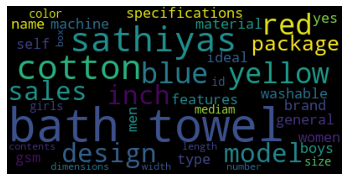

In [ ]:
process_step = 'Tokenisation'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_tokenized']))
print(len(process_step)*'-')

content = data['description_tokenized'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

In [31]:
# another way of cleaning
def clean_2(data,description_clean):
    
    data[description_clean] = data[description_clean].str.lower()

    data[description_clean] = data[description_clean].str.replace('\'','')
    data[description_clean] = data[description_clean].str.replace('\`','')    
    data[description_clean] = data[description_clean].str.replace('\"','')
    data[description_clean] = data[description_clean].str.replace('[','')
    data[description_clean] = data[description_clean].str.replace(']','')    
    data[description_clean] = data[description_clean].str.replace('(','')
    data[description_clean] = data[description_clean].str.replace(')','')
    data[description_clean] = data[description_clean].str.replace('{','')
    data[description_clean] = data[description_clean].str.replace('}','')

    data[description_clean] = data[description_clean].str.replace('@',' ')
    data[description_clean] = data[description_clean].str.replace('?',' ')
    data[description_clean] = data[description_clean].str.replace('!',' ')

    data[description_clean] = data[description_clean].str.replace(';',' ')
    data[description_clean] = data[description_clean].str.replace(',',' ')
    data[description_clean] = data[description_clean].str.replace('.',' ')    
    data[description_clean] = data[description_clean].str.replace(':',' ')

    data[description_clean] = data[description_clean].str.replace('&',' ')
    data[description_clean] = data[description_clean].str.replace('-',' ')
    data[description_clean] = data[description_clean].str.replace('/',' ')
    data[description_clean] = data[description_clean].str.replace('_',' ')
    data[description_clean] = data[description_clean].str.replace('±',' ')
    data[description_clean] = data[description_clean].str.replace('*',' ')
    data[description_clean] = data[description_clean].str.replace('%',' ')

    data[description_clean] = data[description_clean].str.replace('0',' ')
    data[description_clean] = data[description_clean].str.replace('1',' ')
    data[description_clean] = data[description_clean].str.replace('2',' ')
    data[description_clean] = data[description_clean].str.replace('3',' ')
    data[description_clean] = data[description_clean].str.replace('4',' ')
    data[description_clean] = data[description_clean].str.replace('5',' ')
    data[description_clean] = data[description_clean].str.replace('6',' ')
    data[description_clean] = data[description_clean].str.replace('7',' ')
    data[description_clean] = data[description_clean].str.replace('8',' ')
    data[description_clean] = data[description_clean].str.replace('9',' ') 
    
    data[description_clean] = data[description_clean].str.replace('aa',' ')
    data[description_clean] = data[description_clean].str.replace('aaa',' ')

    data[description_clean] = data[description_clean].str.replace('jumpsuit\r\n',' jumpsuit ')
    data[description_clean] = data[description_clean].str.replace('\r\n\t\t\t\t\r\n\t\t\thigh',' thigh ')
    data[description_clean] = data[description_clean].str.replace('quality\xa0aluminum','quality aluminum')    
    data[description_clean] = data[description_clean].str.replace('boys\r\n','boys')
    data[description_clean] = data[description_clean].str.replace('abstrcts','abstract')
    data[description_clean] = data[description_clean].str.replace('asvtwl','')
    data[description_clean] = data[description_clean].str.replace('\r\n\t\t\t\t\r\n\t\t\t',' ') 

    data[description_clean] = data[description_clean].str.replace('   ',' ') 
    data[description_clean] = data[description_clean].str.replace('  ',' ')    
 
    data[description_clean] = data[description_clean].astype('str')

In [32]:
normalization_ = 1
if normalization_ == 1:
    # On normalise les valeurs de la variable temporaire 'content_clean'
    clean_2(data,'description_clean')

In [33]:
tokens_list = []

# Tokenisation avec normalisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i in range(0,len(data)):
    # On tokenise les valeurs de la variale temporaire 'description_clean_1'
    # et on stocke les résultats dans une liste
    tokens_list.append(tokenizer.tokenize(data.loc[i,'description_clean']))
    
# On stocke les tokens dans une nouvelle variable 'content_tok_2'
data['description_clean_tok_2'] = tokens_list
# On supprime la variable temporaire 'content_clean'
#del data['description_clean_1']

data.head(2)

uniq_id  ...                            description_clean_tok_2
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  [key, features, of, elegance, polyester, multi...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  [specifications, of, sathiyas, cotton, bath, t...

[2 rows x 13 columns]

In [ ]:
size_filtre4=word_size(data,'description_clean_tok_2')
print(size_filtre4)

5053


Tokenisation2   Nombre de tokens: 67
-------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


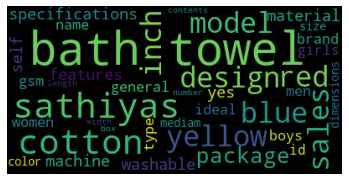

In [ ]:
process_step = 'Tokenisation2'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_clean_tok_2']))
print(len(process_step)*'-')

content = data['description_clean_tok_2'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{5- Stop words}}$

In [34]:
stopword=nltk.corpus.stopwords.words('english')

In [35]:

def remove_sw(text):
  text=[word for word in text if word.lower() not in stopword]
  return text

In [36]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords

data['description_stopword'] = data['description_tokenized'].apply(lambda x: remove_sw(x))
data['name_stopword'] = data['name_tokenized'].apply(lambda x: remove_sw(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stopword'][idex]
print('#text without stopwords#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
size_filtre4=word_size(data,'description_stopword')
print(size_filtre4)

4944


In [ ]:
size_filtre4=word_size(data,'name_stopword')
print(size_filtre4)

1840


stopword   Nombre de stop word: 61
--------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model id color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


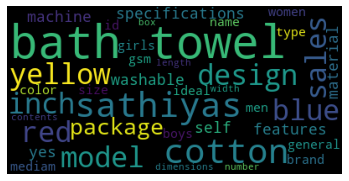

In [ ]:
process_step = 'stopword'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_stopword']))
print(len(process_step)*'-')

content = data['description_stopword'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{5- 2nd stop words}}$

Deleting the words which has just one letter

In [37]:
def rem_short_words(words_list, char_len = 2):
    word_len = [len(i) for i in words_list]
    index_keep = np.array(word_len) > char_len
    words_list_red = np.array(words_list)[index_keep]
    return(list(words_list_red))

In [38]:
from nltk.corpus import stopwords
stop_words_0 = stopwords.words('english')
print('Nombre de stop words (base nltk):',len(stop_words_0))

Nombre de stop words (base nltk): 179


In [39]:
data['description_stw']=data['description_stopword'].apply(rem_short_words)
data['name_stw']=data['name_stopword'].apply(rem_short_words)

In [ ]:
word_size(data,'description_stw')

4867

In [ ]:
word_size(data,'name_stw')

1793

In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stw'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

2nd stopword   Nombre de stw: 60
------------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


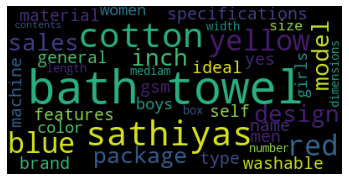

In [ ]:
process_step = '2nd stopword'
print(process_step,'  Nombre de stw:',len(data.loc[p_id,'description_stw']))
print(len(process_step)*'-')

content = data['description_stw'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{6- POS tagging}}$

is a task of labelling each word in a sentence with its appropriate ***part of speech***. We already know that parts of speech include nouns, verb, adverbs, adjectives, pronouns, conjunction and their sub-categories.

https://www.guru99.com/pos-tagging-chunking-nltk.html

In [40]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk import RegexpParser
nltk.sent_tokenize
tag_list = ['NN', 'NNP', 'NNS', 'NNPS']

data['description_pos_tags'] = data['description_stw'].apply(lambda x:[w for w, t in nltk.pos_tag(x) if t in tag_list])
data['name_pos_tags'] = data['name_stw'].apply(lambda x:[w for w, t in nltk.pos_tag(x) if t in tag_list])
data.head(2)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


uniq_id  ...                                      name_pos_tags
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  [elegance, polyester, multicolor, eyelet, door...
1  7b72c92c2f6c40268628ec5f14c6d590  ...                              [cotton, bath, towel]

[2 rows x 19 columns]

In [ ]:
#data['description_pos_tags1'] = data['description_stw'].apply(lambda x:[w for w, t in nltk.pos_tag(x) if t =="NN"])

In [ ]:
#test
text=data.description[0]
print('#text originale#:',text)
text_modifier=data['description_pos_tags'][0]
print('#text modifié#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
word_size(data,'description_pos_tags')

3017

In [ ]:
word_size(data,'name_pos_tags')

1253

POS Tag   Nombre de POS Tag: 43
-------
specifications cotton bath towel bath towel bath towel features machine cotton design brand sathiyas type bath towel gsm model name cotton bath towel men women boys girls model color blue size mediam dimensions width inch box number contents sales package sales bath towel


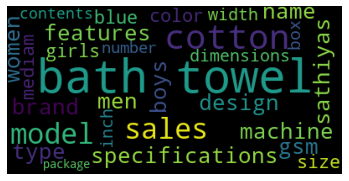

In [ ]:
process_step = 'POS Tag'
print(process_step,'  Nombre de POS Tag:',len(data.loc[p_id,'description_pos_tags']))
print(len(process_step)*'-')

content = data['description_pos_tags'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

### **Reducing the words**
* Stemming
* Lemmatization

$\color{orange}{\text{6- Lemmatization}}$

The real difference between stemming and lemmatization is that Stemming reduces word-forms to (pseudo)stems which might be meaningful or meaningless, whereas lemmatization reduces the word-forms to linguistically valid meaning.

In [41]:
import nltk
nltk.download('wordnet')
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [42]:
data['description_lemma']=data['description_pos_tags'].apply(lambda x : lemmatize_text(x))
data['name_lemma']=data['name_pos_tags'].apply(lambda x : lemmatize_text(x))

In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_lemma'][idex]
print('#text lemma#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
word_size(data,'description_lemma')

2698

In [ ]:
word_size(data,'name_lemma')

1216

description_lemma   Nombre de stop word: 43
-----------------
specification cotton bath towel bath towel bath towel feature machine cotton design brand sathiyas type bath towel gsm model name cotton bath towel men woman boy girl model color blue size mediam dimension width inch box number content sale package sale bath towel


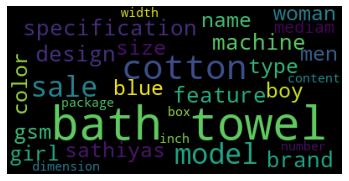

In [ ]:
process_step = 'description_lemma'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_lemma']))
print(len(process_step)*'-')

content = data['description_lemma'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{7- Stemming}}$

In [ ]:
data.head(2)

uniq_id  ...                                             concat
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  key features of elegance polyester multicolor ...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  specifications of sathiyas cotton bath towel b...

[2 rows x 28 columns]

In [43]:
from nltk.stem.snowball import EnglishStemmer
stemm=EnglishStemmer()

def stem_word(text):
  stem_text=[stemm.stem(word)for word in text] 
  return stem_text


In [44]:
data['description_stem'] = data['description_lemma'].apply(lambda x: stem_word(x)) 
data['name_stem'] = data['name_lemma'].apply(lambda x: stem_word(x))

In [ ]:
#test
idex=0
text=data.description_lemma[idex]
print('#text lemma#:',text)
text_modifier=data['description_stem'][idex]
print('#text modifié#  :',text_modifier)

#text lemma#: ['feature', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'price', 'curtain', 'enhances', 'interior', 'quality', 'polyester', 'fabric', 'feature', 'style', 'stitch', 'metal', 'room', 'environment', 'loving', 'curtain', 'wrinkle', 'shrinkage', 'apparance', 'home', 'bright', 'appeal', 'design', 'attention', 'heart', 'eyelet', 'valance', 'curtain', 'thing', 'morning', 'bright', 'sun', 'ray', 'morning', 'world', 'draw', 'evening', 'create', 'moment', 'beauty', 'print', 'home', 'elegant', 'curtain', 'filter', 'room', 'amount', 'specification', 'elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'brand', 'elegance', 'door', 'type', 'eyelet', 'model', 'name', 'polyester', 'door', 'curtain', 'model', 'color', 'multicolor', 'dimension', 'number', 'content', 'sale', 'sale', 'package', 'material', 'polyester']
#text modifié#  : ['featur', 'polyest', 'multicolor', 'eyelet', 'door', 'curtain'

In [ ]:
word_size(data,'description_stem')

2574

supprimer les mots courts

In [45]:
data["description_short"] = data["description_stem"].apply(lambda x: rem_short_words(x))
data["name_short"] = data["name_stem"].apply(lambda x: rem_short_words(x))

In [46]:
word_size(data,'description_short')

2567

In [ ]:
word_size(data,'name_short')

1202

stemming   Nombre de tonek: 43
--------
specif cotton bath towel bath towel bath towel featur machin cotton design brand sathiya type bath towel gsm model name cotton bath towel men woman boy girl model color blue size mediam dimens width inch box number content sale packag sale bath towel


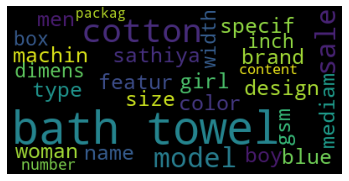

In [ ]:
process_step = 'stemming'
print(process_step,'  Nombre de tonek:',len(data.loc[p_id,'description_short']))
print(len(process_step)*'-')

content = data['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

### **Frequency calculation**

Term frequency answers the question of, how many times does this word appear in this document, how important is this word to this specific document.

The re. compile() method:

With this method we can combine a regular expression pattern into pattern objects, which can be used for pattern matching. It also helps to search a pattern again without rewriting it

In [47]:
# http://pymotw.com/2/re/

import re
#import the regular expressions

corpus=data['description_stem']
words_dico=dict()

expr =re.compile("\W+",re.U) #  method is used to compile a regular expression pattern provided as a string into a regex pattern object (re.Pattern)
for text in corpus:           # re.U. Interprets letters according to the Unicode character set. This flag affects the behavior of \w, \W, \b, \B. 6.
  text = str(text)
  text = expr.split(text)
  for word in set(text): 
    if word not in words_dico:
      words_dico[word]=1
    else: 
          words_dico[word]=words_dico[word]+1



In [ ]:
len(words_dico)

2574

**Frequency exploration**

In [48]:
df_word_freq=pd.DataFrame({'words':words_dico.keys(),'Frequency':words_dico.values()})

In [49]:
df=df_word_freq.sort_values(ascending=False,by='Frequency')
df.head()

words  Frequency
0                   1050
81    product        667
120  deliveri        566
119      cash        564
14      price        542

**Droping all the space**

In [50]:
df_word_freq.drop([0],inplace=True, axis=0)

In [51]:
df_word_freq.sort_values(ascending=False,by='Frequency').head()

words  Frequency
81    product        667
120  deliveri        566
119      cash        564
14      price        542
124       day        513

Text(0.5, 1.0, 'Frequency of words')

<Figure size 1440x720 with 0 Axes>

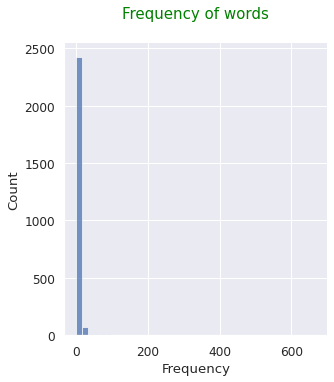

In [ ]:
plt.figure(figsize=(20,10))
sns.displot(data=df_word_freq,bins=40, x="Frequency");
plt.title('Frequency of words', fontsize = 15, pad = 25, color='green')

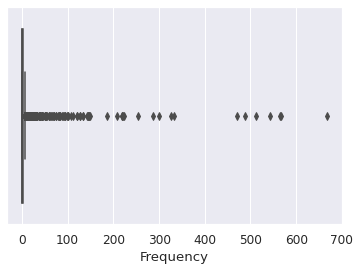

In [ ]:
sns.boxplot(data=df_word_freq,x='Frequency');

In [ ]:
df_word_freq['Frequency'].describe()

count    2573.000000
mean        7.575593
std        35.314685
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       667.000000
Name: Frequency, dtype: float64

In [52]:
sorted_freq=df_word_freq.sort_values(by='Frequency',ascending=False)

In [ ]:
df1=sorted_freq[0:40]

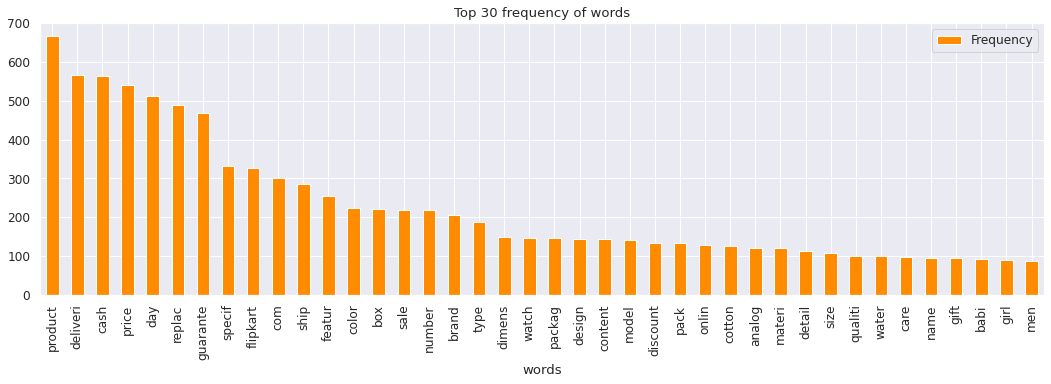

In [ ]:

sns.set(font_scale=1.1)
df1.plot(kind='bar',x='words',y='Frequency',title='Top 30 frequency of words',figsize=(18,5) ,color="darkorange")

In [ ]:
df2=sorted_freq[-41:-1]

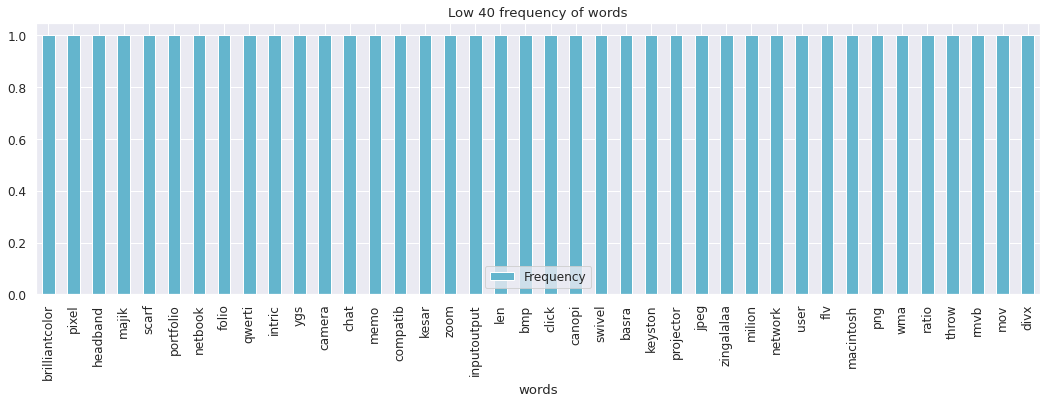

In [ ]:
df2.plot(kind='bar',x='words',y='Frequency', color="c",figsize=(18,5),title='Low 40 frequency of words')

In [ ]:
len(sorted_freq)

3411

**Filtering dataset**

In [ ]:
data.head(2)

uniq_id  ...                                             concat
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  key features of elegance polyester multicolor ...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  specifications of sathiyas cotton bath towel b...

[2 rows x 28 columns]

In [53]:
print(len(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1]),"words are repeated once")

1417 words are repeated once


In [54]:
rem_list = list(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1])
df_word_freq['words'][rem_list].values

array(['wrinkl', 'ray', 'appar', ..., 'decalstick', 'polyvinyl', 'film'],
      dtype=object)

In [ ]:
data['final'] = data['description_short']
data.head(2)

uniq_id  ...                                             concat
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  key features of elegance polyester multicolor ...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  specifications of sathiyas cotton bath towel b...

[2 rows x 28 columns]

### **wordcloud**

In [55]:
df_home= data.loc[data['category']== 'Home']
df_Baby= data.loc[data['category']== 'Baby']
df_Watches= data.loc[data['category']== 'Watches']
df_Decor= data.loc[data['category']== 'Decor']
df_Kitchen= data.loc[data['category']== 'Kitchen']
df_Beauty= data.loc[data['category']== 'Beauty']
df_Computers= data.loc[data['category']== 'Computers']

Text(0.5, 1.0, 'Home Furnishing Categories')

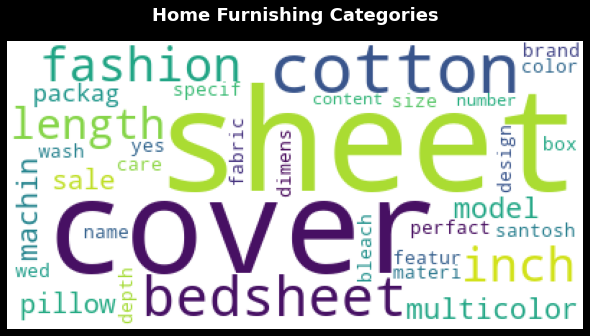

In [56]:
from wordcloud import WordCloud, STOPWORDS

comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_home['description_short']: 
  val = str(val) 
  content = df_home['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Home Furnishing Categories", size=18, color='white',fontweight="bold", pad=20)

Text(0.5, 1.0, 'BabyCare Categories')

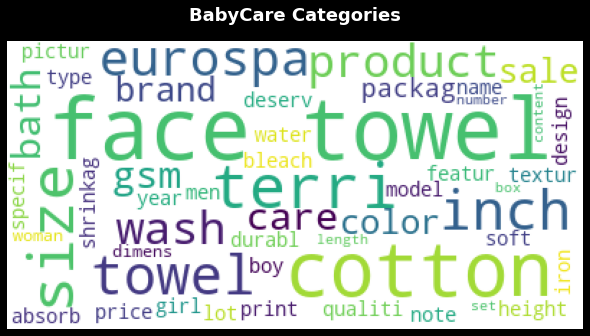

In [ ]:
comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_Baby['description_short']: 
  val = str(val) 
  content = df_Baby['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white',stopwords = stopwords, min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("BabyCare Categories", size=18, color='white',fontweight="bold", pad=20)

Text(0.5, 1.0, 'Watches Categories')

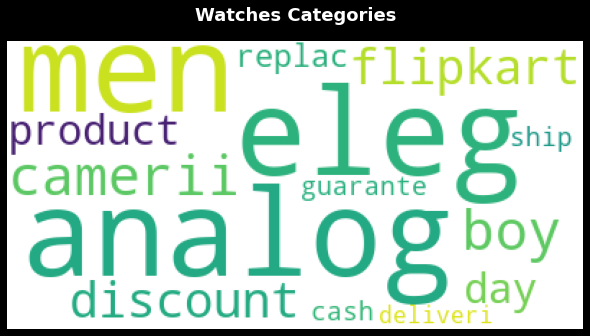

In [ ]:
comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_Watches['description_short']: 
  val = str(val) 
  content = df_Watches['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white',stopwords = stopwords, min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Watches Categories", size=18, color='white',fontweight="bold", pad=20)

Text(0.5, 1.0, 'HomeDecor Categories')

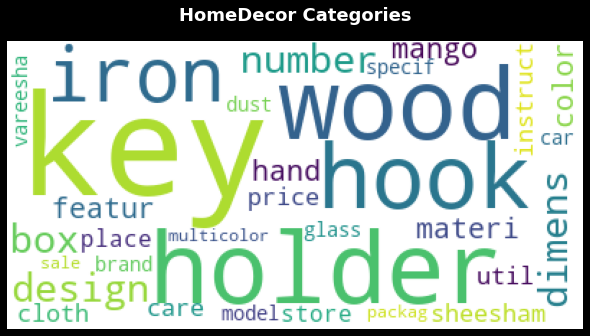

In [ ]:
comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_Decor['description_short']: 
  val = str(val) 
  content = df_Decor['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white',stopwords = stopwords, min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("HomeDecor Categories", size=18, color='white',fontweight="bold", pad=20)

Text(0.5, 1.0, 'Kitchen & Dining Categories')

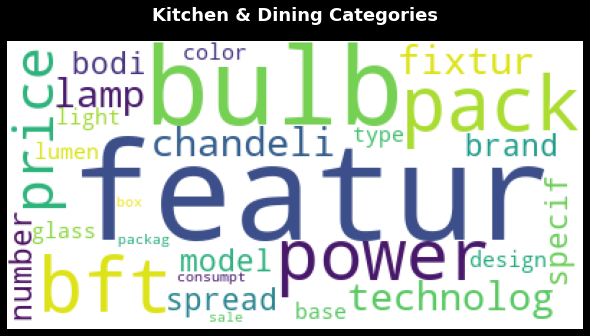

In [ ]:
comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_Kitchen['description_short']: 
  val = str(val) 
  content = df_Kitchen['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white',stopwords = stopwords, min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Kitchen & Dining Categories", size=18, color='white',fontweight="bold", pad=20)

Text(0.5, 1.0, 'Beauty Categories')

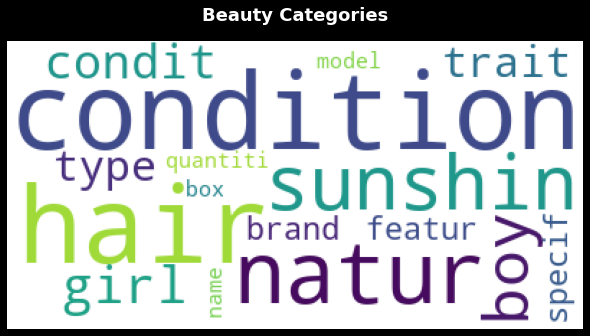

In [ ]:
comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_Beauty['description_short']: 
  val = str(val) 
  content = df_Beauty['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white',stopwords = stopwords, min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Beauty Categories", size=18, color='white',fontweight="bold", pad=20)

Text(0.5, 1.0, 'Computers Categories')

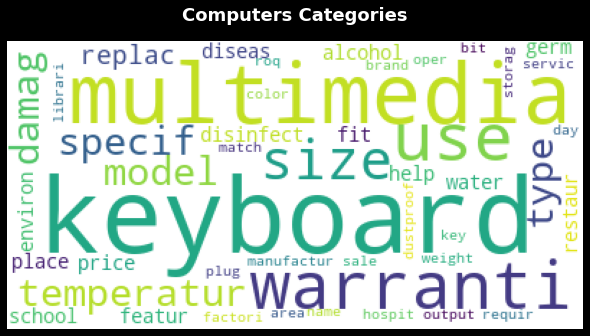

In [ ]:
comment_words_1 = '' 
stopwords = set(STOPWORDS)

for val in df_Computers['description_short']: 
  val = str(val) 
  content = df_Computers['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]

wordcloud_1 = WordCloud(background_color ='white',stopwords = stopwords, min_font_size = 10).generate(content)

plt.figure(figsize = (8, 5), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Computers Categories", size=18, color='white',fontweight="bold", pad=20)

## **Bag of words**

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms.

In [ ]:
data.keys()

Index(['uniq_id', 'image', 'product_name', 'description', 'category',
       'label_category', 'category_1', 'description_clean', 'name_clean',
       'description_tokenized', 'name_tokenized', 'description_clean_tok_2',
       'description_stopword', 'name_stopword', 'description_stw', 'name_stw',
       'description_pos_tags', 'name_pos_tags', 'description_lemma',
       'name_lemma', 'description_stem', 'name_stem', 'description_short',
       'name_short', 'final', 'description_short_', 'name_short_', 'concat'],
      dtype='object')

In [57]:
data['description_short_']= data['description_short'].apply(lambda x: ' '.join(x))
data['name_short_']= data['name_short'].apply(lambda x: ' '.join(x))

In [58]:
#vectorize
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer_1=CountVectorizer( min_df=2,max_df=0.75, stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=(1,1))
tf_matrix_1 = tf_vectorizer_1.fit_transform(data['description_short_'])

In [ ]:
features_names=tf_vectorizer_1.get_feature_names()
#dense=X.todense()
#denselist=dense.tolist()
#word_fre_vect=pd.DataFrame(denselist,columns=features_names)
word_fre_vect_uni=pd.DataFrame(tf_matrix_1.toarray(),columns=tf_vectorizer_1.get_feature_names())
word_fre_vect_uni.head(3)

aapno  abil  abod  absorb  abstract  ...  york  yuva  zipper  zone  zyxel
0      0     0     0       0         0  ...     0     0       0     0      0
1      0     0     0       0         0  ...     0     0       0     0      0
2      0     0     0       1         0  ...     0     0       0     0      0

[3 rows x 1131 columns]

In [ ]:
word_fre_vect_uni.shape

(1050, 266)

In [59]:
df=pd.DataFrame({'Word frequancy': word_fre_vect_uni.max().sort_values(ascending=False).index,'Total':word_fre_vect_uni.max().sort_values(ascending=False).values})

NameError: ignored

In [ ]:
df

Word frequancy  Total
0           product     21
1              bowl     20
2           blanket     19
3             towel     18
4             pizza     17
...             ...    ...
1126         diseas      1
1127         premis      1
1128       dishwash      1
1129         precis      1
1130          zyxel      1

[1131 rows x 2 columns]

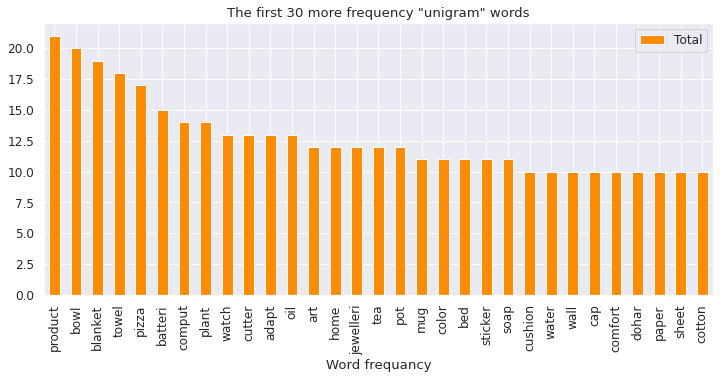

In [ ]:

df1=df.loc[0:30,['Word frequancy','Total']]

df1.plot(kind='bar',x='Word frequancy',y='Total', color="darkorange",title='The first 30 more frequency "unigram" words',figsize=(12,5))


In [60]:
tf_vectorizer_2=CountVectorizer(min_df=2, max_df=0.75,stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=(1,2))
tf_matrix_2 = tf_vectorizer_2.fit_transform(data['description_short_'])

In [61]:
features_names=tf_vectorizer_2.get_feature_names()
word_fre_vect_bi=pd.DataFrame(tf_matrix_2.toarray(),columns=tf_vectorizer_2.get_feature_names())

In [62]:
df_v2=pd.DataFrame({'Word frequancy': word_fre_vect_bi.max().sort_values(ascending=False).index,'Total':word_fre_vect_bi.max().sort_values(ascending=False).values})

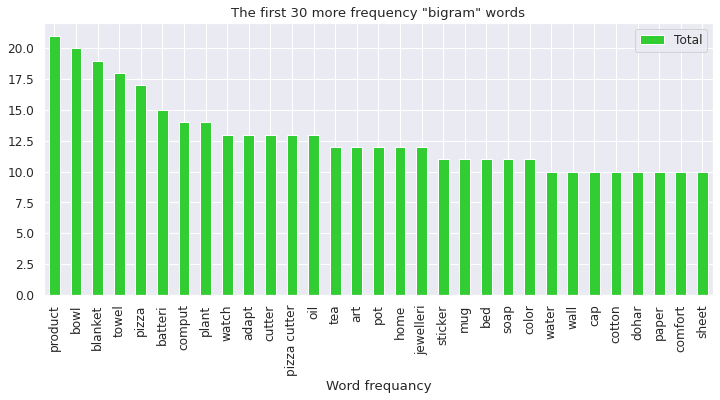

In [ ]:
df2=df_v2.loc[0:30,['Word frequancy','Total']]

df2.plot(kind='bar',x='Word frequancy',y='Total', color="limegreen",title='The first 30 more frequency "unigram & bigram" words',figsize=(12,5))

### **TF IDF**
Term frequency-inverse document frequency

Text vectorization algorithm namely TF-IDF vectorizer, which is a very popular approach for traditional machine learning algorithms can help in transforming text into vectors.
tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification. One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [63]:
# unigrams
tfidf_vectorizer_1 = TfidfVectorizer( min_df=2, max_df=0.75, stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=(1,2))
tfidf_matrix_1 = tfidf_vectorizer_1.fit_transform(data['description_short_'])


In [64]:
features_names=tfidf_vectorizer_1.get_feature_names()
dense=tfidf_matrix_1.todense()
denselist=dense.tolist()
words_freq_1=pd.DataFrame(denselist,columns=features_names)
words_freq_1.head(3)

aapno  aapno rajasthan  abil  abod  ...  yuva  zipper  zone  zyxel
0    0.0              0.0   0.0   0.0  ...   0.0     0.0   0.0    0.0
1    0.0              0.0   0.0   0.0  ...   0.0     0.0   0.0    0.0
2    0.0              0.0   0.0   0.0  ...   0.0     0.0   0.0    0.0

[3 rows x 3424 columns]

In [ ]:
words_freq_1.shape 

(1050, 3424)

In [ ]:
df=pd.DataFrame({'word_freq': words_freq_1.max().sort_values(ascending=False).index,'Total':words_freq_1.max().sort_values(ascending=False).values})

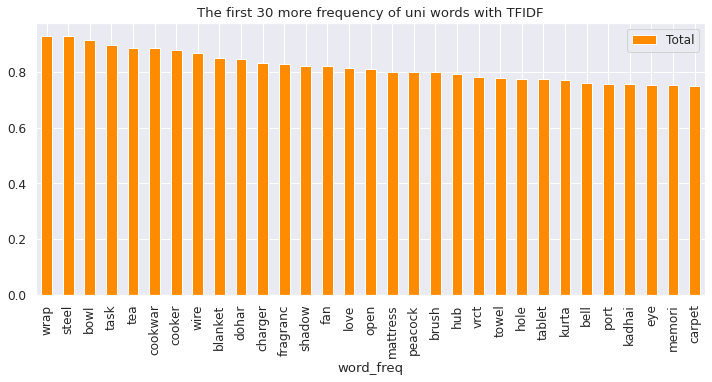

In [ ]:
df1=df.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents 
df1.plot(kind='bar',x='word_freq',y='Total', color="darkorange",title='The first 30 more frequency of unigram words with TFIDF',figsize=(12,5))

In [ ]:
# unigram & bigrams
tfidf_vectorizer_2=TfidfVectorizer(min_df=2,max_df=0.75, stop_words = 'english', analyzer="word", token_pattern=r'\w+',ngram_range=(1,2))
tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(data['description_short_'])

In [ ]:
features_names= tfidf_vectorizer_2.get_feature_names()
dense= tfidf_matrix_2.todense()
denselist= dense.tolist()
words_freq_2= pd.DataFrame(denselist,columns=features_names)
words_freq_2.head(3)

aapno  aapno rajasthan  abil  abod  ...  yuva  zipper  zone  zyxel
0    0.0              0.0   0.0   0.0  ...   0.0     0.0   0.0    0.0
1    0.0              0.0   0.0   0.0  ...   0.0     0.0   0.0    0.0
2    0.0              0.0   0.0   0.0  ...   0.0     0.0   0.0    0.0

[3 rows x 3424 columns]

In [ ]:
words_freq_2.shape

(1050, 3424)

In [ ]:
df_2=pd.DataFrame({'word_freq': words_freq_2.max().sort_values(ascending=False).index,'Total':words_freq_2.max().sort_values(ascending=False).values})


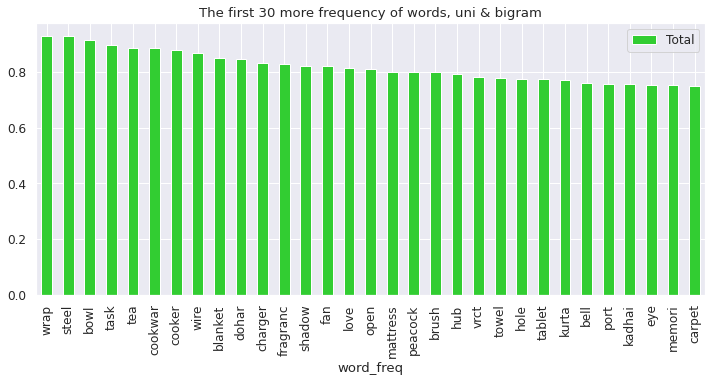

In [ ]:
df1=df_2.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents 
df1.plot(kind='bar',x='word_freq',y='Total', color="limegreen",title='The first 30 more frequency of words, uni & bigram, TFIDF',figsize=(12,5))

In [ ]:
#test
text=data.description[0]
print('#text originale#:',text)
text_modifier=data['description_short_'][0]
print('#text modifié#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [66]:
#define vectorizer parameters
from sklearn.feature_extraction.text import CountVectorizer

def BOVW_TF(X,n_gram):
    tfidf_vectorizer = TfidfVectorizer( min_df = 0.01, max_df=0.7, stop_words = 'english', analyzer="word", token_pattern=r'\w+',  ngram_range=n_gram)
    tf_vectorizer= CountVectorizer( min_df = 0.01,  max_df=0.7,stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=n_gram)
    # Generate matrix of word vectors
    # tf-idf (term frequency-inverse document frequency)
    tfidf_matrix = tfidf_vectorizer.fit_transform(X)
    tfidf_words = tfidf_vectorizer.get_feature_names()

    # bag of words (term frequency)
    tf_matrix=tf_vectorizer.fit_transform(X)
    tf_words = tf_vectorizer.get_feature_names()

    return tfidf_matrix,tf_matrix

In [68]:
data['concat']=data['description_short_']+' '+data['name_short_']

#tfidf_matrix_N,  tf_matrix_N = BOVW_TF(data['name_clean'].copy(),n_gram=(1,2))
tfidf_matrix_NF,  tf_matrix_NF = BOVW_TF(data['name_short_'].copy(),n_gram=(1,2))

#tfidf_matrix_D,  tf_matrix_D = BOVW_TF(data['description_clean'].copy(),n_gram=(1,1))
tfidf_matrix_DF,  tf_matrix_DF = BOVW_TF(data['description_short_'].copy(),n_gram=(1,1))

#uni & bi
#tfidf_matrix_D_b,  tf_matrix_D_b  =  BOVW_TF(data['description_clean'].copy(),n_gram=(1,2))
tfidf_matrix_DF_b,  tf_matrix_DF_b =  BOVW_TF(data['description_short_'].copy(),n_gram=(1,2))

In [131]:
print('CV, unigram shape:  ', tf_matrix_DF.shape)
print('CV, uni et bigram shape:  ',tf_matrix_DF_b.shape)

print('TFIDF, unigram shape:  ', tfidf_matrix_DF.shape)
print('TFIDF, uni et bigram shape: ',tfidf_matrix_DF_b.shape)

CV, unigram shape:   (1050, 266)
CV, uni et bigram shape:   (1050, 483)
TFIDF, unigram shape:   (1050, 266)
TFIDF, uni et bigram shape:  (1050, 483)


### **Dimentional reduction**

In [146]:
#https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE

def plot_tsne_pca(matrix, title, labels):

# Dimensionality reduction using PCA,

    pca = PCA(n_components=2, random_state=5).fit_transform(matrix)
    tsne = TSNE(n_components=2, random_state=5).fit_transform(matrix)  
    
    #attaching the label to each 2D projection
    pca_data = np.vstack((pca.T,labels)).T
    pca_df = pd.DataFrame(pca_data, columns=['pca-one','pca-two','category'])

    tsne_data = np.vstack((tsne.T,labels)).T
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne-one','tsne-two','category'])
   
    #idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)
    f, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.scatterplot(data= pca_df, x="pca-one", y="pca-two", hue='category', ax=ax[0])
    ax[0].set_title('PCA Cluster Plot'+' '+title)

    sns.scatterplot(data= tsne_df, x="tsne-one", y="tsne-two", hue='category', ax=ax[1])
    ax[1].set_title('TSNE Cluster Plot'+' '+title)

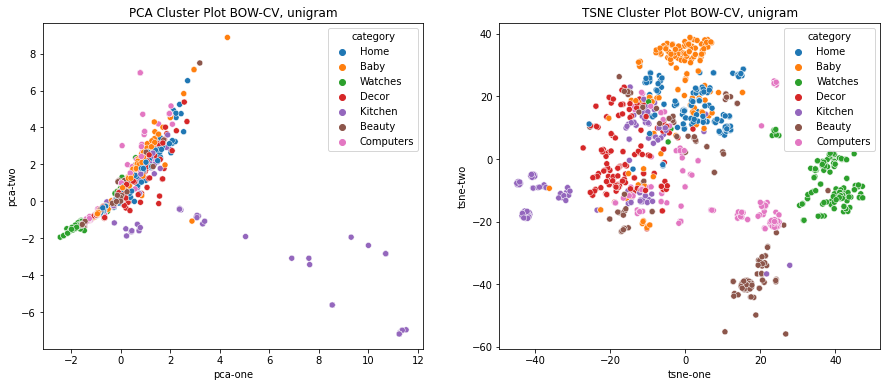

In [141]:
plot_tsne_pca(tf_matrix_DF.todense(),'BOW-CV, unigram',data['category'])

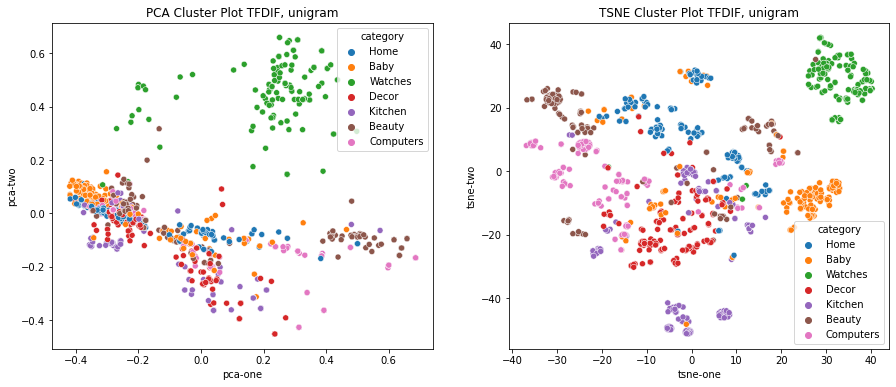

In [142]:
plot_tsne_pca(tfidf_matrix_DF.todense(),'TFDIF, unigram',data['category'])

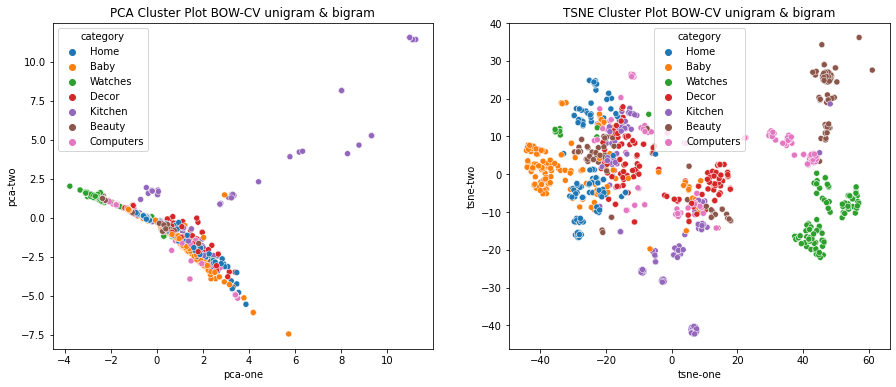

In [143]:
plot_tsne_pca(tf_matrix_DF_b.todense(),'BOW-CV unigram & bigram',data['category'])

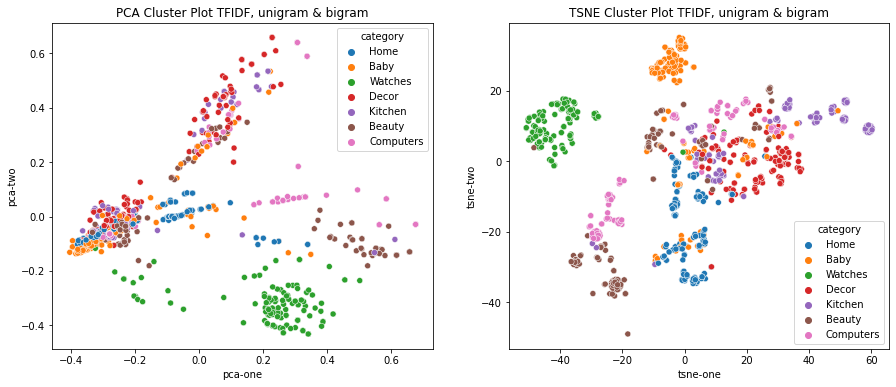

In [144]:
plot_tsne_pca(tfidf_matrix_DF_b.todense(),'TFIDF, unigram & bigram',data['category'])

## Word2Vec

Word2Vec (W2V) is an algorithm that accepts text corpus as an input and outputs a vector representation for each word

https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [71]:
from gensim.models import Word2Vec
from gensim.utils import tokenize
sentences = [list(tokenize(s, deacc=True, lower=True)) for s in data['description_short_']]

# Model
model = Word2Vec(sentences, min_count=10, size=10)
print('model:',model)
print('')

# Vocabulaire
words = list(model.wv.vocab)
print('words:',words)


model: Word2Vec(vocab=450, size=10, alpha=0.025)

words: ['featur', 'polyest', 'multicolor', 'eyelet', 'door', 'curtain', 'eleg', 'price', 'interior', 'qualiti', 'fabric', 'style', 'metal', 'room', 'love', 'home', 'design', 'morn', 'world', 'beauti', 'print', 'specif', 'brand', 'type', 'model', 'name', 'color', 'dimens', 'number', 'content', 'sale', 'packag', 'materi', 'cotton', 'bath', 'towel', 'machin', 'gsm', 'men', 'woman', 'boy', 'girl', 'blue', 'size', 'width', 'inch', 'box', 'face', 'height', 'product', 'care', 'year', 'durabl', 'note', 'pictur', 'wash', 'water', 'iron', 'bleach', 'length', 'set', 'fashion', 'bedsheet', 'cover', 'yes', 'sheet', 'pillow', 'depth', 'king', 'jaipur', 'comfort', 'bed', 'hand', 'look', 'life', 'thread', 'warranti', 'manufactur', 'pack', 'time', 'analog', 'watch', 'flipkart', 'com', 'discount', 'day', 'replac', 'guarante', 'ship', 'cash', 'deliveri', 'way', 'work', 'accessori', 'rest', 'crystal', 'glass', 'round', 'need', 'rang', 'custom', 'art', 'spo

In [83]:
word_ = 'watch'

# Vecteur pour un mot
print(model[word_])

[ 1.6163515  -0.7407534   0.62906903  1.5321897  -0.8846718   1.9484899
 -1.8268656  -0.3888677   0.6863854  -0.7900773 ]


In [84]:
model.most_similar(word_, topn=10)

[('men', 0.9990598559379578),
 ('analog', 0.9963006377220154),
 ('woman', 0.9913076162338257),
 ('maximum', 0.964187502861023),
 ('com', 0.9531118273735046),
 ('flipkart', 0.9480050802230835),
 ('strap', 0.9432399272918701),
 ('discount', 0.9409545063972473),
 ('sonata', 0.9405615329742432),
 ('decker', 0.9226694703102112)]

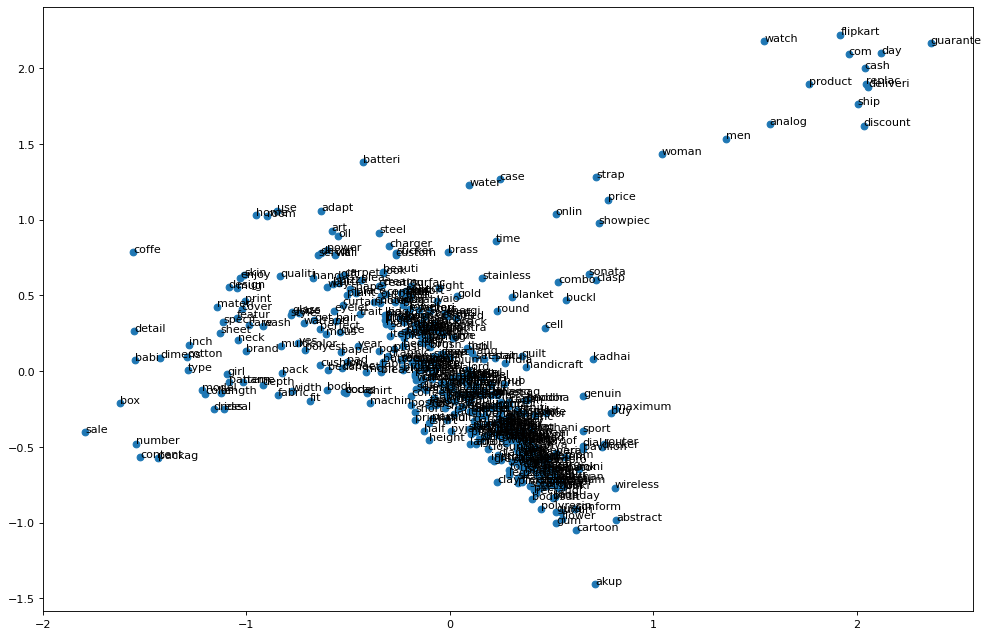

In [82]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# # create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)

for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

In [ ]:
X.shape

(450, 10)

## Modeling

In [ ]:
#W2V
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
  nbw= len(phrase.split())
  return sum(get_vect(w, model) for w in phrase)/nbw
    
def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

#X_emb_N = word2vec_features(data['name_clean'].copy(), model)
#X_emb_NF = word2vec_features(data['name_fin'].copy(), model)

X_emb_DF = word2vec_features(data['description_short_'].copy(), model)

X_emb_DF.shape

(1050, 10)

Non-Negative Matrix Factorization (**NMF**). ... This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

**LDA** ( short for Latent Dirichlet Allocation ) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic. A topic is represented as a weighted list of words

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

**SVD** (Singular Value Decomposition) is a widely used technique to decompose a matrix into several component matrices, exposing many of the useful and interesting properties of the original matrix.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

## Clustering

In [85]:
k=7#nbr of cluster
def kmeans_clustering(tfidf_matrix, tf_matrix,k):

    # Singular Value Decomposition
    svd = TruncatedSVD(n_components=100)
    svd_tfidf = svd.fit_transform(tfidf_matrix_DF)
    svd_tf = svd.fit_transform(tf_matrix_DF)

    km_tfidf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(tfidf_matrix_DF) 
    km_tf = KMeans(n_clusters = k,init = 'random', n_init = 50, random_state = 24, algorithm = 'full').fit(tf_matrix_DF)
   
    km_svd_tf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(svd_tfidf)# svd-based k-means 
    km_svd_tfidf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(svd_tf) 

    return km_tfidf, km_tf, km_svd_tf, km_svd_tfidf

In [ ]:
#nmf_matrix_N, lda_tf_N, km_tfidf_N,km_tf_N,km_nmf_N,km_lsa_tf_N,km_lsa_tfidf_N,km_lda_N,km_emb_N=kmeans_clustering(tfidf_matrix_1,tf_matrix_1,X_emb_N,k=7)
#nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF=kmeans_clustering(tfidf_matrix_2,tf_matrix_2 ,X_emb_NF,k=7)

In [86]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(7, max_iter=5, learning_method='online',learning_offset=50.,random_state=24,)
lda_tf = lda.fit_transform(tf_matrix_DF)
lda_tf


array([[0.00244005, 0.00242166, 0.98543757, ..., 0.00242276, 0.0024272 ,
        0.00242397],
       [0.0035746 , 0.00357518, 0.00358476, ..., 0.00357999, 0.00357211,
        0.00357609],
       [0.00186154, 0.00186061, 0.13656051, ..., 0.00186159, 0.00186049,
        0.00186653],
       ...,
       [0.01299554, 0.72697573, 0.01299351, ..., 0.2080519 , 0.01299705,
        0.01299427],
       [0.00840819, 0.44461997, 0.00840702, ..., 0.51334217, 0.00840852,
        0.00840761],
       [0.01099588, 0.602989  , 0.01099427, ..., 0.34203614, 0.01099684,
        0.01099493]])

In [88]:
# unigram
km_tfidf_D,  km_tf_D, km_svd_tf_D,  km_svd_tfidf_D =  kmeans_clustering(tfidf_matrix_D, tf_matrix_D, k=7)
km_tfidf_DF, km_tf_DF, km_svd_tf_DF, km_svd_tfidf_DF = kmeans_clustering(tfidf_matrix_DF, tf_matrix_DF,k=7)

In [89]:
# uni & bigram
km_tfidf_D_b,  km_tf_D_b, km_svd_tf_D_b,  km_svd_tfidf_D_b =  kmeans_clustering(tfidf_matrix_D_b,tf_matrix_D_b,k=7)
km_tfidf_DF_b, km_tf_DF_b, km_svd_tf_DF_b, km_svd_tfidf_DF_b = kmeans_clustering(tfidf_matrix_DF_b,tf_matrix_DF_b,k=7)

In [90]:
def data_cluster(km_tfidf, km_tf, km_svd_tf, km_svd_tfidf):
  df = pd.DataFrame(columns=['cluster_svd_tfidf', 'cluster_svd_tf', 'cluster_tfidf', 'cluster_tf',], index=range(1050))

  df['cluster_svd_tfidf']=km_svd_tfidf.labels_
  df['cluster_svd_tf']=km_svd_tf.labels_

  df['cluster_tfidf']=km_tfidf.labels_
  df['cluster_tf']=km_tf.labels_
  return df

In [91]:
# uni

#df_name=data_cluster(nmf_matrix_N,lda_tf_N,km_tfidf_N,km_tf_N,km_nmf_N,km_lsa_tf_N,km_lsa_tfidf_N,km_lda_N,km_emb_N)
#df_name_final=data_cluster(nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF)

df_desc_vec_u  = data_cluster(km_tfidf_D, km_tf_D, km_svd_tf_D, km_svd_tfidf_D)
df_desc_tfidf_uf= data_cluster(km_tfidf_DF, km_tf_DF,km_svd_tf_DF, km_svd_tfidf_DF)

In [92]:
# uni & bi
df_desc_vec_ub  = data_cluster(km_tfidf_D_b,  km_tf_D_b, km_svd_tf_D_b,  km_svd_tfidf_D_b)
df_desc_tfidf_ubf= data_cluster(km_tfidf_DF_b, km_tf_DF_b, km_svd_tf_DF_b, km_svd_tfidf_DF_b)

In [93]:
def Ari_score (df, label, label_tru):
  cluster  = {0:'Baby',
            1:'Decor',
            2:'Computers',
            3:'Watches',
            4:'Kitchen',
            5:'Home',
            6:'Beauty'}

  # Prep
  k_labels = df[label].map(cluster)  # Get cluster labels
  k_labels_matched = np.empty_like(k_labels)

  # For each cluster label...
  for k in np.unique(k_labels):

  # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(label_tru==t)) for t in np.unique(label_tru)]
    k_labels_matched[k_labels==k] = np.unique(label_tru)[np.argmax(match_nums)]
  #confusion_matrix
  #conf_mat = confusion_matrix(label_tru, k_labels_matched)

  #compute ARI SCORE
  ari_score=adjusted_rand_score(label_tru, k_labels_matched)
  
  return ari_score

In [94]:
def data_ari(df,Title):
    liste=['cluster_svd_tfidf','cluster_svd_tf','cluster_tfidf','cluster_tf']

    ARI=[]
    for cluster in liste:
      ari=Ari_score (df,cluster, data['category'])
      ARI.append([ari])

    df_ari=pd.DataFrame(ARI, index=['svd_tfidf_km','svd_tf_km','tfidf_km', 'tf_km'],
                             columns=['ARI_SCORE'])
  
    #display scores of  each Scaler
    tab_score=df_ari.round(3)

    #plot bar each Scaler 
    barWidth = 0.25

    r1 = np.arange(len(tab_score))
    r2 = [x + barWidth for x in r1]
    fig, ax = plt.subplots(figsize=(8,5))

    rec1=ax.bar(r1, tab_score['ARI_SCORE'], color='darkorange', width=barWidth, label='ARI_SCORE')

    for rect in rec1 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')

    # add some text for labels, title and axes ticks
    ax.set_title('Comparaison des performances Kmeans'+' '+Title, fontsize = 20)
    ax.set_xlabel('Models', fontsize = 15)
    ax.set_ylabel('Scores', fontsize = 15)
    ax.set_ylim(top=1)
    plt.xticks(r1, tab_score.index)
    ax.legend()
    plt.show()

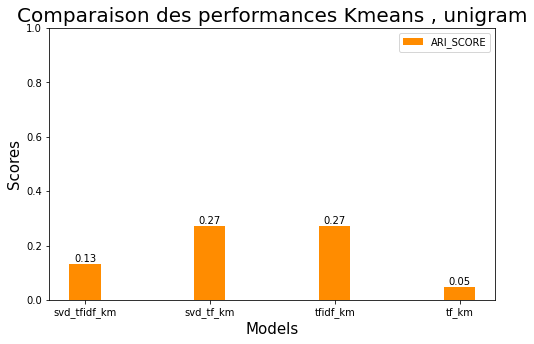

In [95]:
data_ari(df_desc_tfidf_uf,', unigram')

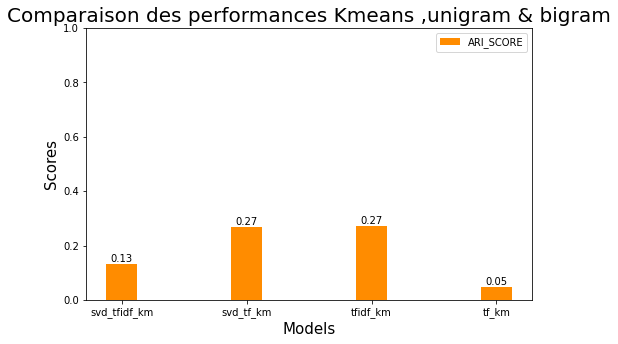

In [96]:
data_ari(df_desc_tfidf_ubf,',unigram & bigram')

In [149]:
data.head(2)

uniq_id  ... cluster_tfidf
0  55b85ea15a1536d46b7190ad6fff8ce7  ...             5
1  7b72c92c2f6c40268628ec5f14c6d590  ...             0

[2 rows x 30 columns]

In [99]:
from sklearn.metrics import make_scorer, adjusted_rand_score
from sklearn.model_selection import GridSearchCV

km = KMeans(n_clusters= 7)
score = make_scorer(adjusted_rand_score)

# hyperparametres
parameters = {'init':('k-means++', 'random'),
              'max_iter':[50,100,120],#Nombre de fois où l'algorithme k-means sera exécuté avec différentes valeurs de centroïde. Les résultats finaux seront la meilleure sortie de n_init exécutions consécutives en termes d'inertie.
              'n_init':[5,10,15],#Nombre maximum d'itérations de l'algorithme k-means pour une seule exécution.
              'algorithm':['auto', 'full', 'elkan'],#Algorithme K-means à utiliser
              'random_state': [20,25,30,40,60,]}#Détermine la génération de nombres aléatoires pour l'initialisation du centre de gravité. Utilisez un int pour rendre le caractère aléatoire déterministe

#recherche sur gride
grid = GridSearchCV(km, parameters, scoring=score)
grid.fit(tfidf_matrix_DF, data.label_category)
index_grid = grid.cv_results_['rank_test_score'].tolist().index(1)

print("ARI score mean :"+ str(grid.cv_results_['mean_test_score'][index_grid]))
print("Best parameters: "+ str(grid.best_params_))

ARI score mean :0.3381826204814973
Best parameters: {'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 5, 'random_state': 20}


In [100]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++' , n_init =5 , random_state = 20, algorithm = 'auto', max_iter=50 ).fit(tfidf_matrix_DF) 

In [101]:
labels_ts = kmeans.labels_

In [123]:
from sklearn.metrics import confusion_matrix
data['cluster_tfidf']= labels_ts

In [112]:
from sklearn import cluster, metrics
metrics.confusion_matrix(data.label_category, data['cluster_tfidf'])

array([[ 11,  85,   5,   1,   9,  39,   0],
       [  0,   0,  28,   0,   0, 122,   0],
       [  0,   0,  76,   0,   0,  74,   0],
       [  0,   1,   1,   0,   0,   7, 141],
       [  0,   0,  28,  73,   1,  48,   0],
       [ 19,   5,   3,   0,  67,  56,   0],
       [  0,   0,  82,   0,   0,  68,   0]])

In [113]:
np.argmax(confusion_matrix(data['label_category'], data['cluster_tfidf']), axis=1)

array([1, 5, 2, 6, 3, 4, 2])

In [114]:
y_true = data.label_category

In [151]:
conf_mat =metrics.confusion_matrix(y_true, data['cluster_tfidf'])
corresp = np.argmax(conf_mat, axis=0)
labels = pd.Series(y_true, name="y_true").to_frame()

labels['y_pred'] = data['cluster_tfidf'].apply(lambda x : corresp[x])


conf_mat = metrics.confusion_matrix(y_true, labels['y_pred'])
conf_mat

array([[ 85,  39,   0,   0,   1,  20,   5],
       [  0, 122,   0,   0,   0,   0,  28],
       [  0,  74,   0,   0,   0,   0,  76],
       [  1,   7,   0, 141,   0,   0,   1],
       [  0,  48,   0,   0,  73,   1,  28],
       [  5,  56,   0,   0,   0,  86,   3],
       [  0,  68,   0,   0,   0,   0,  82]])

In [118]:
from sklearn import cluster, metrics

print(metrics.classification_report(y_true, labels['y_pred']))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71       150
           1       0.29      0.81      0.43       150
           2       0.00      0.00      0.00       150
           3       1.00      0.94      0.97       150
           4       0.99      0.49      0.65       150
           5       0.80      0.57      0.67       150
           6       0.37      0.55      0.44       150

    accuracy                           0.56      1050
   macro avg       0.63      0.56      0.55      1050
weighted avg       0.63      0.56      0.55      1050



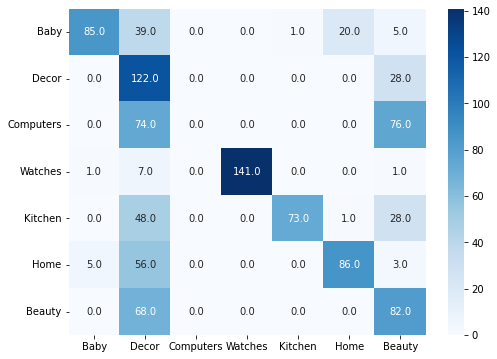

In [119]:
list_labels=['Baby','Decor','Computers','Watches','Kitchen','Home','Beauty']
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels], columns = [label for label in list_labels])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, fmt='.1f', cmap="Blues")

In [164]:
cluster  = {0:'Baby',
            1:'Decor',
            2:'Computers',
            3:'Watches',
            4:'Kitchen',
            5:'Home',
            6:'Beauty'}

labels_pred = labels['y_pred'].map(cluster)
plot_tsne_pca(tfidf_matrix_DF,'TFIDF_cluster', labels_pred)

TypeError: ignored

In [159]:
from PIL import Image
from random import *
path = "/content/drive/MyDrive/p6/Images/"
def test(index):
    im = Image.open(path+ flipkart.image[index])
    print('Name:  ',flipkart['product_name'].iloc[index])
    print('categorie: ',data['category'].iloc[index])

    print('cluster: ',labels_pred.iloc[index])

    plt.figure(figsize=(7,7))
    plt.imshow(im)

Name:   Elegance Polyester Multicolor Abstract Eyelet Door Curtain
categorie:  Home
cluster:  Decor


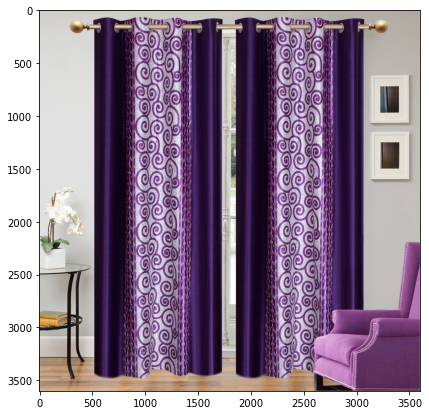

In [160]:
test(0)

Name:   Nike Original Combo Set
categorie:  Beauty
cluster:  Beauty


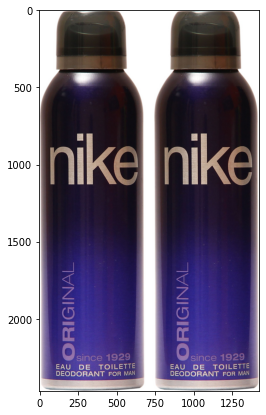

In [161]:
test(377)

Name:   Elite Collection Medium Acrylic Sticker
categorie:  Baby
cluster:  Decor


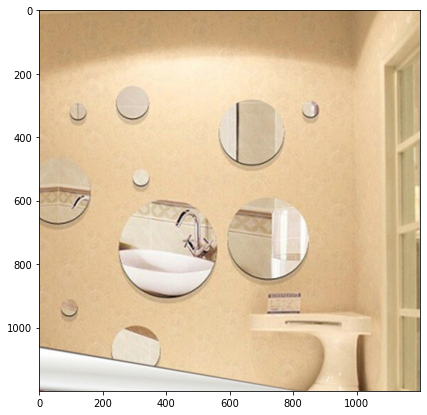

In [162]:
test(1040)

Name:   TRUE Bong
categorie:  Decor
cluster:  Beauty


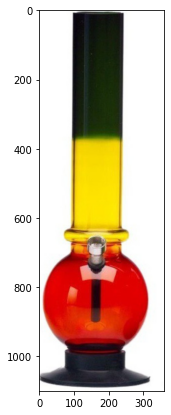

In [167]:
test(250)

Name:   Filink 310 Black Toner
categorie:  Computers
cluster:  Decor


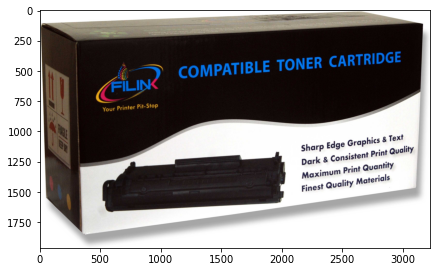

In [169]:
test(115)